<a href="https://colab.research.google.com/github/jwaldroup/odw-2021/blob/master/ConnectToLISACatalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A demo for using google colab with `lisacattools`

This demo shows how to 

1.   Install `lisacattools`
2.   Install the respective catalogs
3.   Run a short example

using the Google colab environment.

## Why this demo?
This demo is meant for users who do not have accsss to local resources or want to use Google colab for the easy access to GPU or TensorFlow resources or just want to give the colab environment a test drive.

### Drawbacks of using colab

Above all, keep in mind that Google colab runs inside a virtual machine (VM) on Google infrastructure. Due to the nature of a VM, the initial steps of installing `lisacattools` and the installation of the catalogs have to be repeated everytime the VM restarts.

Also, you have to make sure that the modules you want to use are installed in the VM. This can be easily done via `pip`. 

## Install `lisacattools`
This is a good example of how to use `pip` to install python packages unknown to colab. Use `-q` to stop the process from chattering.

In [ ]:
!pip install lisacattools -q

     |████████████████████████████████| 15.8MB 248kB/s 
     |████████████████████████████████| 19.3MB 146kB/s 
     |████████████████████████████████| 11.6MB 42.0MB/s 
     |████████████████████████████████| 9.7MB 28.8MB/s 
     |████████████████████████████████| 4.3MB 28.1MB/s 
     |████████████████████████████████| 9.9MB 13.1MB/s 
     |████████████████████████████████| 143kB 32.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3MB 25.9MB/s 
     |████████████████████████████████| 2.3MB 25.8MB/s 
     |████████████████████████████████| 1.3MB 26.8MB/s 
     |████████████████████████████████| 215kB 45.8MB/s 
     |████████████████████████████████| 27.3MB 111kB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 1.6MB 26.3MB/s 
     |████████████████████████████████| 2.6MB 33.3MB/s 
     |█████████████████████████████

## Install the catalogs
Using data stored on Googl Drive (your own or of somebody else) requires authentication. The next cell takes care of that.

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



Downloading the two tar-files into the filesystem of the colab virtual machine. We use a copy of the original `data_download` script and simply execute that after download. This might take a while.

In [ ]:
!mkdir -p scripts && wget -q -O scripts/data_download.py https://raw.githubusercontent.com/tlittenberg/lisacattools/main/scripts/data_download.py
!python scripts/data_download.py

1.9 GiB Done.
5.0 GiB Done.
1.2 GiB Done.


## Run a short example

Once you reach this stage, your environment as far as the installation of the catalogs is conceren is set up. 

As an example, we use an adaptation of [`plot_source_Mc_DL.py`](https://raw.githubusercontent.com/tlittenberg/lisacattools/main/docs/examples_ucb/plot_source_Mc_DL.py) that has been changed to read the catalogs from the VM file system. 

### Additional adjustments
The `chainconsumer` packaage is not installed be default, so this is another call to `pip`. Also TeX does not come automatically installed - use `apt-get` to fix that.

In [ ]:
!pip install chainconsumer -q 
!pip install matplotlib --upgrade -q

In [ ]:
from chainconsumer import ChainConsumer
from lisacattools.catalog import GWCatalog, GWCatalogs, GWCatalogType
from lisacattools import get_DL, get_Mchirp
import matplotlib.pyplot as plt

In [ ]:
!apt-get -qq update
!apt-get -qq install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Start by loading the main catalog files processed from GBMCMC outputs. Make sure that you set the catalog path to the directory we installed the catalogs in

In [ ]:
catPath = "tutorial/data/ucb"
catalogs = GWCatalogs.create(GWCatalogType.UCB, catPath, "cat15728640_v2.h5")
final_catalog = catalogs.get_last_catalog()
detections_attr = final_catalog.get_attr_detections()
detections = final_catalog.get_detections(detections_attr)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Sort table by SNR and select highest SNR source

In [ ]:
detections.sort_values(by="SNR", ascending=False, inplace=True)
sourceId = detections.index[0]
samples = final_catalog.get_source_samples(sourceId)

Init the memory cache
(lisacattools.utils._read_chain_file:127) 2021-06-28 19:38:40,566 INFO utils newfunc Init the memory cache


INFO:lisacattools.utils._read_chain_file:Init the memory cache


Cache LDC0092117281-cat15728640_v2_chains_1100s.h5
(lisacattools.utils._read_chain_file:130) 2021-06-28 19:38:40,571 INFO utils newfunc Cache LDC0092117281-cat15728640_v2_chains_1100s.h5


INFO:lisacattools.utils._read_chain_file:Cache LDC0092117281-cat15728640_v2_chains_1100s.h5


Reject chain samples with negative fdot (enforce GR-driven prior)

In [ ]:
samples_GR = samples[(samples["Frequency Derivative"] > 0)]

Add distance and chirpmass to samples

In [ ]:
get_DL(samples_GR)
get_Mchirp(samples_GR)

Make a corner plot

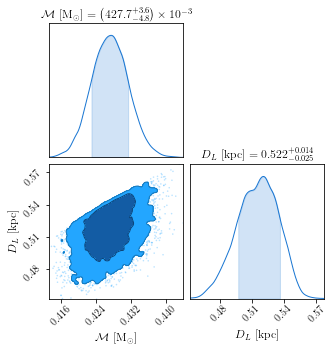

In [ ]:
parameters = ["Chirp Mass", "Luminosity Distance"]
parameter_symbols = [r"$\mathcal{M}\ [{\rm M}_\odot]$", r"$D_L\ [{\rm kpc}]$"]

df = samples_GR[parameters].values

c = ChainConsumer().add_chain(df, parameters=parameter_symbols, cloud=True)
c.configure(flip=False)
fig = c.plotter.plot(figsize=1.5)
plt.show()